In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df=Train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')


In [4]:

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Define a function to map each month to its ordinal value
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

# Global categorical columns and encoders
categorical_cols = []
encoders = {}

# -----------------------------
# 1. Preprocessing + Encoding
# -----------------------------
def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# 2. Model Building
# -----------------------------
def build_model(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"\u2705 Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_23560\3580636383.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Model trained on 100.0% of data
Accuracy: 0.8109
Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.54      0.32      0.40       863
         non functional       0.85      0.79      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



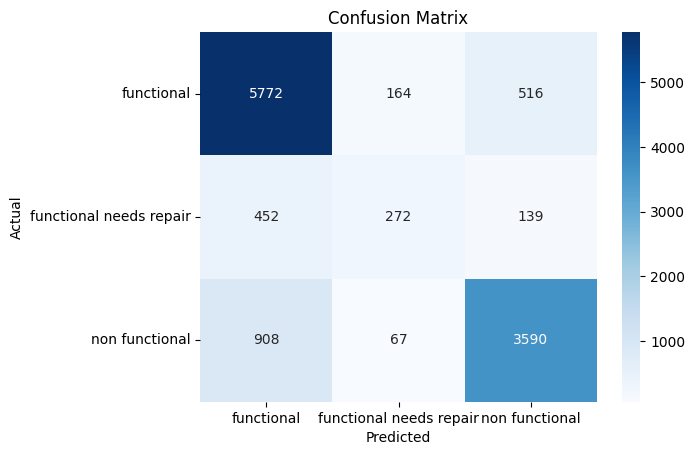

In [10]:
rf_model=build_model(df, data_proportion=1, n_estimators=300, max_depth=None, random_state=42)

In [6]:
model_data=rf_model
predict_test_set(model_data, test_set_values)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23560\3580636383.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


✅ Saved 14850 predictions to predictions_2025-04-09_17-27-11.csv


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


---

# Trying wrapper method

In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

# 2. Model Building with Feature Selection (Wrapper Method)
# -----------------------------
def build_model_with_wrapper(df, num_features=15, data_proportion=1.0, n_estimators=350, max_depth=None, random_state=42):
    df = clean_encode(df, is_train=True)
    y = df['status_group']
    X = df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    base_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    selector = RFE(estimator=base_model, n_features_to_select=num_features, step=1)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    selected_features = X_train.columns[selector.support_]
    print("Selected features:", list(selected_features))

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Model trained on {data_proportion*100:.1f}% of data")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model,
        'selector': selector,
        'selected_features': selected_features
    }

# -----------------------------
# 3. Predict on Test Set
# -----------------------------
def predict_test_set_wrapper(model_data, test_df):
    test_df_cleaned = clean_encode(test_df, is_train=False)
    model = model_data['model']
    selector = model_data['selector']

    X_test = test_df_cleaned[model_data['selected_features']]
    X_test_selected = selector.transform(X_test)

    predictions = model.predict(X_test_selected)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_23560\440030689.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)


Selected features: ['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'subvillage', 'region', 'lga', 'ward', 'population', 'scheme_name', 'construction_year', 'extraction_type_group', 'extraction_type_class', 'payment', 'quantity', 'quantity_group', 'waterpoint_type_group']
Model trained on 80.0% of data
Accuracy: 0.8043
Precision: 0.7982
Recall: 0.8043
F1 Score: 0.7965

Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      5161
functional needs repair       0.57      0.32      0.41       691
         non functional       0.84      0.77      0.80      3652

               accuracy                           0.80      9504
              macro avg       0.74      0.66      0.69      9504
           weighted avg       0.80      0.80      0.80      9504



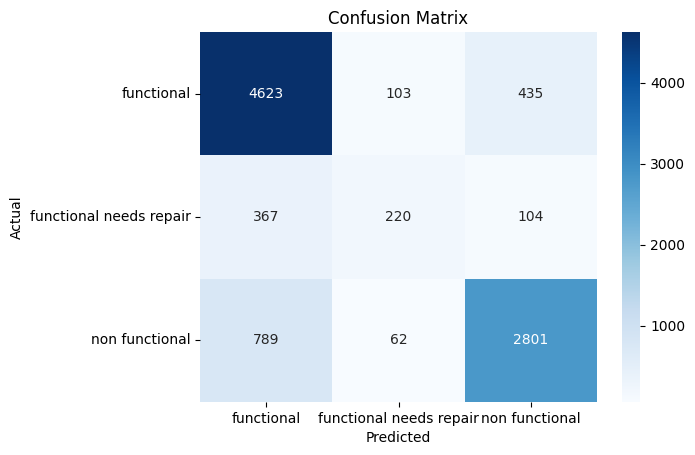

{'model': RandomForestClassifier(n_estimators=550, random_state=42),
 'selector': RFE(estimator=RandomForestClassifier(n_estimators=550, random_state=42),
     n_features_to_select=20),
 'selected_features': Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
        'latitude', 'subvillage', 'region', 'lga', 'ward', 'population',
        'scheme_name', 'construction_year', 'extraction_type_group',
        'extraction_type_class', 'payment', 'quantity', 'quantity_group',
        'waterpoint_type_group'],
       dtype='object')}

In [ ]:
build_model_with_wrapper(df, num_features=20,data_proportion=0.2)
